In [1]:
from __future__ import annotations
import os
import pandas as pd
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
import itertools
import random
import json
import pickle
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("font", size=18)
mpl.rcParams["font.family"] = "Liberation Serif"

In [2]:
# https://insights.stackoverflow.com/survey/2020#technology-most-loved-dreaded-and-wanted-languages-loved
loved_languages = {
    "rust":        86.1,
    "typescript":  67.1,
    "python":      66.7,
    "kotlin":      62.9,
    "go":          62.3,
    "dart":        62.1,
    "c#":          59.7,
    "javascript":  58.3,
    "haskell":     51.7,
    "java":        44.1,
    "c++":         43.4,
    "ruby":        42.9,
    "c":           33.1,
    "perl":        28.6,
    "objective-c": 23.4,
    "vba":         19.6,
}

In [4]:
# Collect all data into single dataframe
qdfs = list()
adfs = list()
cdfs = list()
for lang in tqdm(loved_languages):
    qf = os.path.join("data", lang, "questions.pkl")
    af = os.path.join("data", lang, "answers.pkl")
    cf = os.path.join("data", lang, "comments.pkl")
    qdfs.append(pd.read_pickle(qf))
    qdfs[-1]["language"] = lang
    qdfs[-1]["type"] = "q"
    adfs.append(pd.read_pickle(af))
    adfs[-1]["language"] = lang
    adfs[-1]["type"] = "a"
    cdfs.append(pd.read_pickle(cf))
    cdfs[-1]["language"] = lang
    cdfs[-1]["type"] = "c"

# Shuffle to prevent systematic biases in contiguous subsets of dataframe
so = pd.concat(qdfs + adfs + cdfs, ignore_index=True).sample(frac=1)
del qdfs, adfs, cdfs

# Remove half of data, as there is otherwise too much to handle
qids = set(so.question_id)
qids = { qid for qid in qids if random.random() > 0.5 }
so = so[[row.question_id in qids for _, row in tqdm(so.iterrows(), total=len(so))]]

100%|██████████| 2539774/2539774 [03:06<00:00, 13587.78it/s]


In [5]:
# Data summary
t = Table()
t.add_header(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in tqdm(loved_languages):
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print("Number of items in dataset")
print(t)

100%|██████████| 16/16 [00:13<00:00,  1.17it/s]
Number of items in dataset
Language    | Questions | Answers | Comments | Total    
Rust        |     6,568 |   7,990 |   25,064 |    39,622
Typescript  |    12,148 |  17,624 |   45,889 |    75,661
Python      |    13,069 |  18,220 |   52,151 |    83,440
Kotlin      |     8,042 |  12,519 |   29,449 |    50,010
Go          |    12,911 |  17,240 |   47,053 |    77,204
Dart        |     5,964 |  10,001 |   21,623 |    37,588
C#          |    12,953 |  16,342 |   59,989 |    89,284
Javascript  |    12,932 |  17,977 |   54,266 |    85,175
Haskell     |    10,914 |  15,122 |   50,664 |    76,700
Java        |    13,081 |  17,127 |   54,224 |    84,432
C++         |    13,124 |  17,788 |   81,992 |   112,904
Ruby        |    13,099 |  18,252 |   52,792 |    84,143
C           |    13,102 |  20,042 |   95,939 |   129,083
Perl        |     9,776 |  15,519 |   55,379 |    80,674
Objective-c |    11,900 |  14,580 |   48,485 |    74,965
Vba         |

In [6]:
# Regex for matching stopwords
sw = r"\b(" + "|".join(stopwords.words("english")) + r")\b"

def clean(text: str) -> str:
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    # Remove everything that is not alpha-numeric
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("Before cleaning")
print("  Words:         %s" % thousand_seps(words))
print("  Avg. per sub.: %.2f" % (words / len(so)))
print("  Characters:    %s" % thousand_seps(chars))
print("  Avg. per sub.: %.2f" % (chars / len(so)))

print("\nCleaning text")
so["clean"] = [clean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.clean)
chars = sum(len(body) for body in so.clean)
print("\nAfter cleaning")
print("  Words:         %s" % thousand_seps(words))
print("  Avg. per sub.: %.2f" % (words / len(so)))
print("  Characters:    %s" % thousand_seps(chars))
print("  Avg. per sub.: %.2f" % (chars / len(so)))

  0%|          | 937/1272873 [00:00<02:15, 9356.58it/s]Before cleaning
  Words:         86,190,338
  Avg. per sub.: 67.71
  Characters:    704,514,132
  Avg. per sub.: 553.48

Cleaning text
100%|██████████| 1272873/1272873 [02:06<00:00, 10037.42it/s]

After cleaning
  Words:         51,598,507
  Avg. per sub.: 40.54
  Characters:    473,333,440
  Avg. per sub.: 371.86


In [7]:
# Save data for later use
so.to_pickle("data.pkl")

In [3]:
so = pd.read_pickle("data.pkl")

In [4]:
# Classifier part starts here. Body will no longer be needed, so removed from dataset to save memory
del so["body"]

In [9]:
# Build lookup table to get all submissions with given question ID
subs_by_id = defaultdict(list)
for _, row in tqdm(so.iterrows(), total=len(so)):
    subs_by_id[row.question_id].append(row)
subs_by_id = { question_id: pd.DataFrame(rows) for question_id, rows in tqdm(subs_by_id.items()) }

100%|██████████| 180867/180867 [04:06<00:00, 732.46it/s]


In [11]:
def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

<ipython-input-11-a2e7594aafef>:2: RuntimeWarning: divide by zero encountered in log10
  def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):


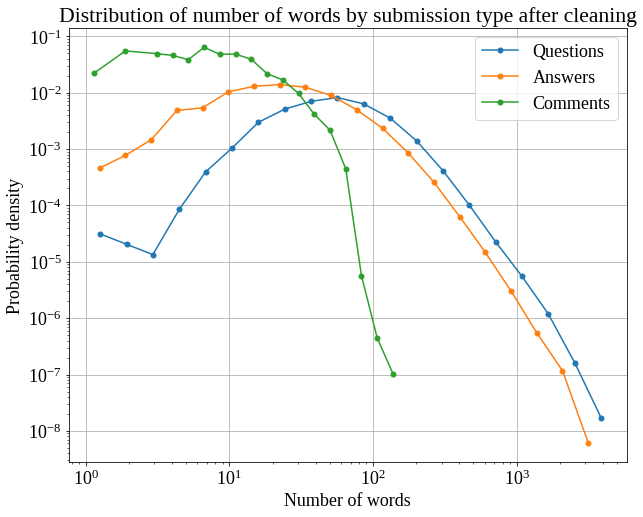

In [11]:
# Plot distribution of words
qx, qdist = bins(np.array([len(text.split()) for text in so.clean[so.type=="q"]]))
ax, adist = bins(np.array([len(text.split()) for text in so.clean[so.type=="a"]]))
cx, cdist = bins(np.array([len(text.split()) for text in so.clean[so.type=="c"]]))

fig, ax_ = plt.subplots(figsize=(10, 8))
ax_.plot(qx, qdist, marker=".", ms=10, label="Questions")
ax_.plot(ax, adist, marker=".", ms=10, label="Answers")
ax_.plot(cx, cdist, marker=".", ms=10, label="Comments")
ax_.grid(True)
ax_.set_xscale("log")
ax_.set_yscale("log")
ax_.set_title("Distribution of number of words by submission type after cleaning")
ax_.set_xlabel("Number of words")
ax_.set_ylabel("Probability density")
ax_.legend()

In [6]:
train_format = "local_train_%s.txt"
val_format = "local_val_%s.txt"

In [12]:
# Combine texts by programming language and split into train and validation
train_validation_split = 0.9
n_train_qs = int(train_validation_split * len(subs_by_id))
q_ids = list(subs_by_id)
q_ids_train = q_ids[:n_train_qs]
q_ids_val = q_ids[n_train_qs:]

keys = list(subs_by_id)
for lang in loved_languages:
    try:
        os.remove(train_format % lang)
        os.remove(val_format % lang)
    except FileNotFoundError:
        pass
for i, qid in tqdm(enumerate(keys), total=len(subs_by_id)):
    subs = subs_by_id[qid]
    lang = subs.iloc[0].language
    if lang not in loved_languages:
        continue
    if qid in q_ids_train:
        with open(train_format % lang, "a") as ftrain:
            ftrain.write(" ".join(itertools.chain(*(b.split() for b in subs.clean))) + " ")
    else:
        with open(val_format % lang, "a") as fval:
            fval.write(" ".join(itertools.chain(*(b.split() for b in subs.clean))) + "\n")
    del subs_by_id[qid]  # No longer needed, so clear from memory
del subs_by_id

100%|██████████| 180867/180867 [29:58<00:00, 100.57it/s]


In [7]:
train_texts = dict()
val_texts = dict()
for lang in tqdm(loved_languages):
    with open(train_format % lang) as f:
        train_texts[lang] = f.read().split()
    with open(val_format % lang) as f:
        val_texts[lang] = [words.split() for words in f.read().split("\n")]

100%|██████████| 16/16 [00:04<00:00,  3.95it/s]


Text(0, 0.5, 'Number of words')

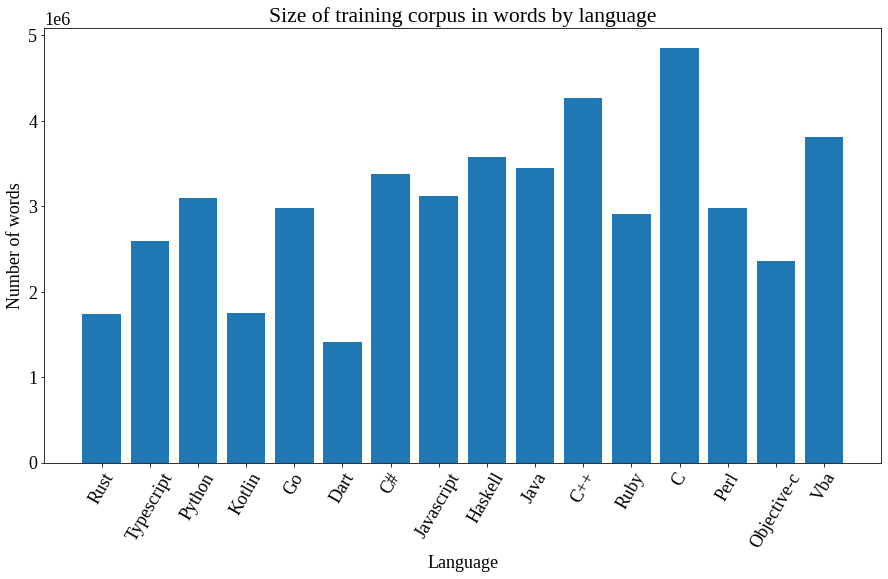

In [8]:
# Corpus size distribution
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.bar(range(len(loved_languages)), [len(corpus) for corpus in train_texts.values()], tick_label=[x.capitalize() for x in train_texts])
ax.tick_params(axis="x", rotation=60)
ax.set_title("Size of training corpus in words by language")
ax.set_xlabel("Language")
ax.set_ylabel("Number of words")

In [9]:
# Build classifier using TF-IDF
def top(counts: dict, n: int) -> dict:
    """ Takes a dict { key: count } and returns a dict with the n key-count pairs with highest counts """
    n_highest = sorted(counts.values())[-n] if n <= len(counts) else min(counts.values())
    return { key: count for key, count in counts.items() if count >= n_highest }

tfidf = dict()  # { language: { word: TF-IDF score } }
counts = { lang: Counter(train_texts[lang]) for lang in tqdm(loved_languages) }
for lang in tqdm(loved_languages):
    # Count of each for given language
    c = counts[lang]
    # Calculate TF and IDF
    tf = { word: count / len(train_texts[lang]) for word, count in c.items() }
    idf = {
        word: np.log(
            len(c) /\
            (1 + sum(word in vocab for vocab in counts.values()))
        )
        for word in c
    }
    tfidf[lang] = { word: tf[word] * idf[word] for word in c }

100%|██████████| 16/16 [00:31<00:00,  1.96s/it]


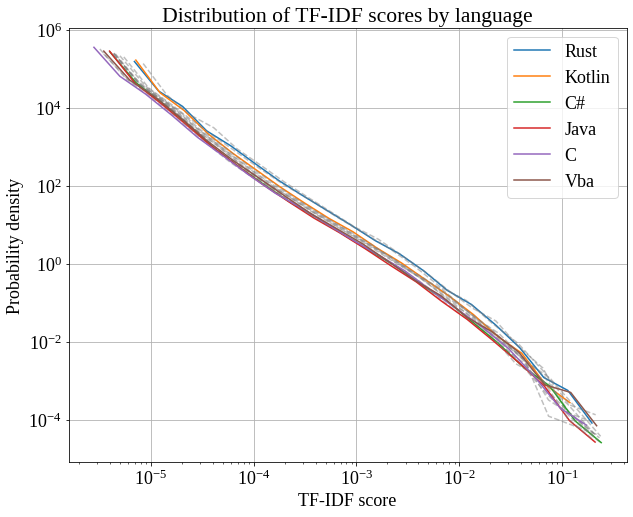

In [12]:
plt.figure(figsize=(10, 8))
for i, (lang, tfidf_scores) in enumerate(tfidf.items()):
    x, y = bins(sorted(tfidf_scores.values()), lambda x, b: np.logspace(min(np.log10(x)), max(np.log10(x)), b))
    if i % 3 == 0:
        plt.plot(x, y, label=lang.capitalize())
    else:
        plt.plot(x, y, c="gray", ls="--", alpha=0.5)
plt.title("Distribution of TF-IDF scores by language")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("TF-IDF score")
plt.ylabel("Probability density")
plt.grid()
plt.legend()


In [13]:
def classify(text: str, cleaned=True, tfidf_: dict=None) -> tuple[str, dict]:
    """
    Classify text by TF-IDF scores by summing TF-IDF for every word in every language and selecting language with highest score
    Returns language and probability distribution over all languages
    An optional TF-IDF dict can be given. Default is the tfidf variable
    """
    tfidf_ = tfidf_ or tfidf
    # Make sure text is cleaned
    if not cleaned:
        text = clean(text)
    word_counts = Counter(text.split())
    scores = dict()
    langs = list(tfidf_.keys())
    for lang, word_tfidf in tfidf_.items():
        scores[lang] = 0
        for word, count in word_counts.items():
            scores[lang] += word_tfidf.get(word, 0)
        if scores[lang] == 0:
            scores[lang] = -float("inf")
    # Calculate probability distribution using softmax
    prob = scipy.special.softmax(np.array(list(scores.values())))
    if np.any(np.isnan(prob)):  # In case of no known words
        return None, None
    return langs[prob.argmax()], prob

  0%|          | 0/5 [00:00<?, ?it/s]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 20%|██        | 1/5 [00:11<00:45, 11.48s/it]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 40%|████      | 2/5 [00:23<00:36, 12.03s/it]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 60%|██████    | 3/5 [00:36<00:24, 12.20s/it]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
 80%|████████  | 4/5 [00:49<00:12, 12.67s/it]/home/a

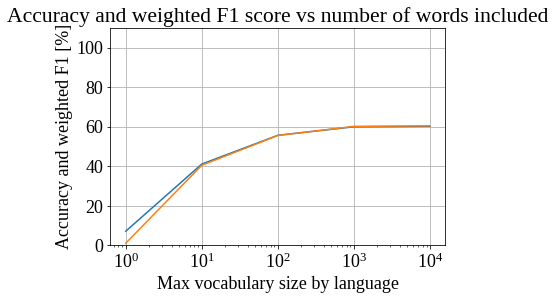

In [17]:
# Build confusion matrix for classification
def get_conf_mat(tfidf_: dict=None):
    """ Get confusion matrix over threads using a given tfidf dict """
    conf_mat = np.zeros((len(loved_languages), len(loved_languages)), dtype=int)
    lang_indices = { lang: i for i, lang in enumerate(loved_languages) }
    for lang, i in lang_indices.items():
        texts = val_texts[lang]
        for words in texts:
            pred, _ = classify(" ".join(words), tfidf_=tfidf_)
            if pred is not None:
                conf_mat[lang_indices[pred], i] += 1
    return conf_mat

def f1(conf_mat: np.ndarray) -> float:
    """ Calculate weighted f1 score for a given confusion matrix """
    per_class = conf_mat.sum(axis=0)  # Number of submissions by class
    # Generate fake true and pred vectors that satisfy conf mat to calculate f1 score
    y_true = np.array(list(itertools.chain(*([i]*per_class[i] for i in range(len(conf_mat))))))
    y_pred = np.zeros_like(y_true)
    idx = 0
    for i in range(len(conf_mat)):  # True class
        for j in range(len(conf_mat)):  # Predicted class
            y_pred[idx:idx+conf_mat[j, i]] = j
            idx += conf_mat[j, i]
    return f1_score(y_true, y_pred, average="weighted")

# Get prediction accuracy and weighted f1 for differect vocab sizes
n = 5
number_of_words = np.logspace(0, n-1, n, dtype=int)
accs = list()
f1s = list()
for n_words in tqdm(number_of_words):
    tfidf_ = { lang: top(tfidf[lang], n_words) for lang in tfidf }
    conf_mat = get_conf_mat(tfidf_)
    acc = np.diagonal(conf_mat).sum() / conf_mat.sum()
    accs.append(acc)
    f1s.append(f1(conf_mat))
plt.plot(number_of_words, 100*np.array(accs), label="Accuracy")
plt.plot(number_of_words, 100*np.array(f1s), label="Weighted F1")
plt.ylim([0, 110])
plt.xscale("log")
plt.grid()
plt.title("Accuracy and weighted F1 score vs number of words included")
plt.xlabel("Max vocabulary size by language")
plt.ylabel("Accuracy and weighted F1 [%]")
plt.legend()
with open(os.path.join("data", "accs_f1.json"), "w") as f:
    json.dump({
        "number_of_words": number_of_words.tolist(),
        "accs": accs,
        "f1s": f1s,
    }, f)

In [26]:
# Only save for 10k vocab size, as more is redundant
with open(os.path.join("data", "tfidf.json"), "w", encoding="utf-8") as f:
    json.dump({ lang: top(tfidf[lang], 10**3) for lang in tfidf }, f)

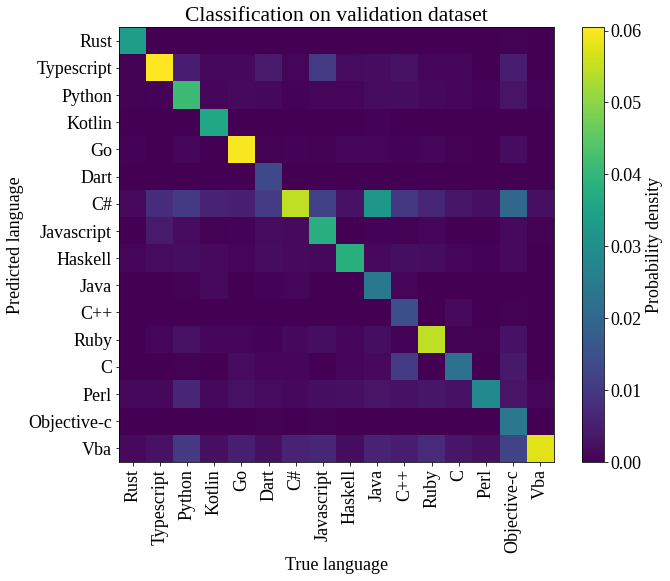

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = ax.imshow(conf_mat/conf_mat.sum())
ax.set_xticks(range(len(loved_languages)))
ax.set_xticklabels([lang.capitalize() for lang in loved_languages])
ax.set_yticks(range(len(loved_languages)))
ax.set_yticklabels([lang.capitalize() for lang in loved_languages])
ax.set_title("Classification on validation dataset")
ax.set_xlabel("True language")
ax.set_ylabel("Predicted language")
ax.tick_params(axis="x", rotation=90)
bar = fig.colorbar(pos)
bar.set_label("Probability density")